# Aufgabe5 – Interpretation von Modellen

## Notebook Beschreibung
...

## Bibliotheken importieren und Notebook setup

In [345]:
# Modul Pfad setzen
import sys
sys.path.append('./module')


# Bibliotheken importieren
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC


import statsmodels.api as sm
import statsmodels.formula.api as smf

from IPython.display import display


## Analyse und Datenvorverarbeitung

Aufgabe 5a)  
Lesen Sie den Datensatz Hdma.csv ein und machen Sie sich mit den Daten vertraut.

In [251]:
# Load Dataset from csv (use ; as separator)
data = pd.read_csv('./data/Hdma.csv', sep=';')
# Display first line to test if data was loaded correctly
data.head()

,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,condo,black,deny
0,0.221,0.221,0.800000,5.0,2.0,no,no,no,no,3.9,0,no,no
1,0.265,0.265,0.921875,2.0,2.0,no,no,no,yes,3.2,0,no,no
2,0.372,0.248,0.920398,1.0,2.0,no,no,no,no,3.2,0,no,no
3,0.320,0.250,0.860465,1.0,2.0,no,no,no,no,4.3,0,no,no
4,0.360,0.350,0.600000,1.0,1.0,no,no,no,no,3.2,0,no,no


In [252]:
# Show dataframe size
data.shape

(2381, 13)

Der Datensatz besteht aus 2381 Datenpunkten mit jeweils 13 Merkmalen

In [253]:
data.isnull().any()

dir       False
hir       False
lvr       False
ccs       False
mcs       False
pbcr       True
dmi       False
self       True
single    False
uria      False
condo     False
black     False
deny      False
dtype: bool

Die Spalten "pbcr" und "self" enthalten fehlende Daten.

In [254]:
data[data.isnull().any(axis=1)]

,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,condo,black,deny
2380,0.330814,0.255346,0.700783,2.116387,1.721008,NaN,no,NaN,yes,3.774496,0,no,no


Nur in einer Zeile ist "pbcr" und "self" gleich NaN. Da es nur eine einzige Zeile mit fehlenden Daten gibt, haben wir uns entschieden diese aus dem Datensatz zu entfernen.

In [255]:
data = data.drop(2380)
data.shape

(2380, 13)

### Art der Merkmale 

In [256]:
data.columns

Index(['dir', 'hir', 'lvr', 'ccs', 'mcs', 'pbcr', 'dmi', 'self', 'single',
       'uria', 'condo', 'black', 'deny'],
      dtype='object')

- `dir` numerisch-kontinuierlich 
- `hir` numerisch-kontinuierlich
- `lvr` numerisch-kontinuierlich
- `ccs` kategorisch-ordinal
- `mcs` kategorisch-ordinal
- `pbcr` kategorisch-nominal
- `dmi` kategorisch-nominal
- `self` kategorisch-nominal
- `single` kategorisch-nominal
- `uria` numerisch-kontinuierlich
- `condo` kategorisch-nominal
- `black` kategorisch-nominal
- `deny` kategorisch-nominal


Die Zielvariable der Klassifikation ist 'deny' welche angibt ob der Kreditantrag abgelehnt wurde. Es soll bestimmt werden welche Merkmale besonderen Einfluss auf diese haben. Im Speziellen soll bestimmt werden, ob es eine rassistische Diskriminierung gibt. Dafür muss das Merkmal 'black' betrachtet werden

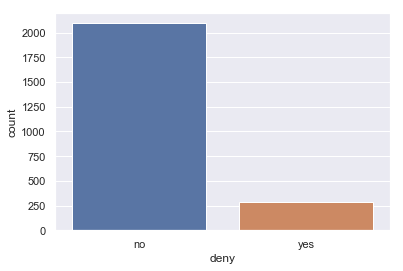

Not denied: 88.0%
Denied: 12.0%


In [257]:
sns.countplot(x='deny',data=data)
plt.show()
percentages = data['deny'].value_counts() / data.shape[0]
print("Not denied: {:.1f}%".format(percentages[0] * 100))
print("Denied: {:.1f}%".format(percentages[1] * 100))

In [258]:
nominal_features = ['pbcr', 'dmi', 'self', 'single', 'condo', 'black', 'deny']
labelencoder = LabelEncoder()
data[nominal_features] = data[nominal_features].apply(labelencoder.fit_transform)
data.head()

,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,condo,black,deny
0,0.221,0.221,0.800000,5.0,2.0,0,0,0,0,3.9,0,0,0
1,0.265,0.265,0.921875,2.0,2.0,0,0,0,1,3.2,0,0,0
2,0.372,0.248,0.920398,1.0,2.0,0,0,0,0,3.2,0,0,0
3,0.320,0.250,0.860465,1.0,2.0,0,0,0,0,4.3,0,0,0
4,0.360,0.350,0.600000,1.0,1.0,0,0,0,0,3.2,0,0,0


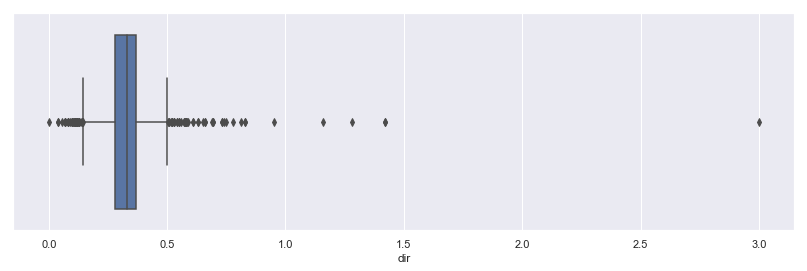

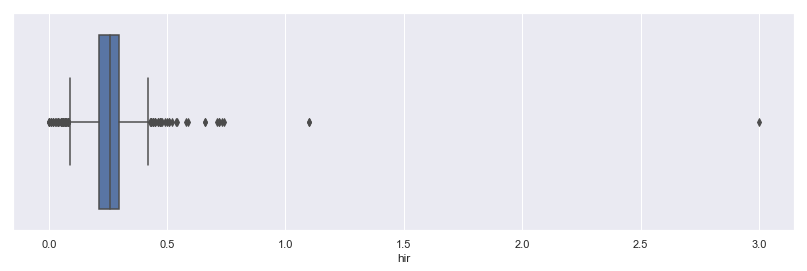

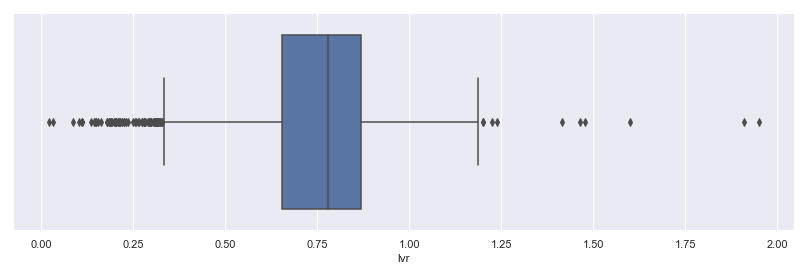

In [259]:
continuous_features = ['dir', 'hir', 'lvr']
for feature in continuous_features:
    plt.figure(figsize=(14, 4))
    sns.boxplot(data[feature])
    plt.show()

In [260]:
outliers = data[data["dir"]>2]
outliers.head()

,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,condo,black,deny
1094,3.0,3.0,0.571429,1.0,3.0,0,0,1,0,10.6,0,0,1


In [261]:
data.drop(outliers.index, inplace=True)
data.shape

(2379, 13)

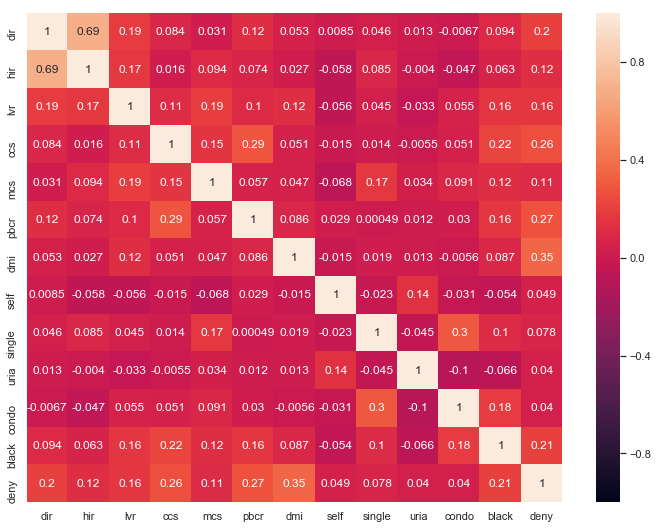

In [262]:
correlation_matrix = data.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmin=-1,vmax=1,annot=True)
plt.show()

In [263]:
# Create numpy arrays for features and target
X = data.drop(["deny"], axis=1)
y = data["deny"]
# Create 80/20 train val split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
# Print resulting dataset sizes
print("Shape X_train", X_train.shape)
print("Shape y_train", y_train.shape)
print("Shape X_test", X_test.shape)
print("Shape y_test", y_test.shape)

Shape X_train (1903, 12)
Shape y_train (1903,)
Shape X_test (476, 12)
Shape y_test (476,)


Wir haben uns dazu entschieden die Daten nicht zu normalisieren (z.B. durch einen StandardScaler). Hierdurch können die gelernten Koeffizienten besser interpretiert werden. Es muss daher aber auch beachtet werden, dass ein höherer Koeffizient nicht zwingend eine höhere Wichtigkeit des Merkmals bedeutet.

Im Folgenden verwenden wir die statsmodels Pythonbibliothek, um die logistische Regression zu trainieren. Diese bietet gegenüber scikit-learn weitere statistische Kennwerte, wie zum Beispiel den P-Wert jedes Koeffizienten, der die Signifikanz beschreibt.

In [333]:
logistic_regression = smf.Logit(y_train, sm.add_constant(X_train))
result = logistic_regression.fit()
coef_table = result.summary2().tables[1].round(4)
test_prediction_proba = result.predict(sm.add_constant(X_test)) 
test_prediction_class = test_prediction_proba > 0.5
print("Accuracy score: {:.3f}".format(metrics.accuracy_score(y_test, test_prediction_class)))
print("Balanced accuracy score:{:.3f}".format(metrics.balanced_accuracy_score(y_test, test_prediction_class)))

Optimization terminated successfully.
         Current function value: 0.270975
         Iterations 7
Accuracy score: 0.918
Balanced accuracy score:0.642


/Users/d062356/miniconda3/envs/smart-data-analytics/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


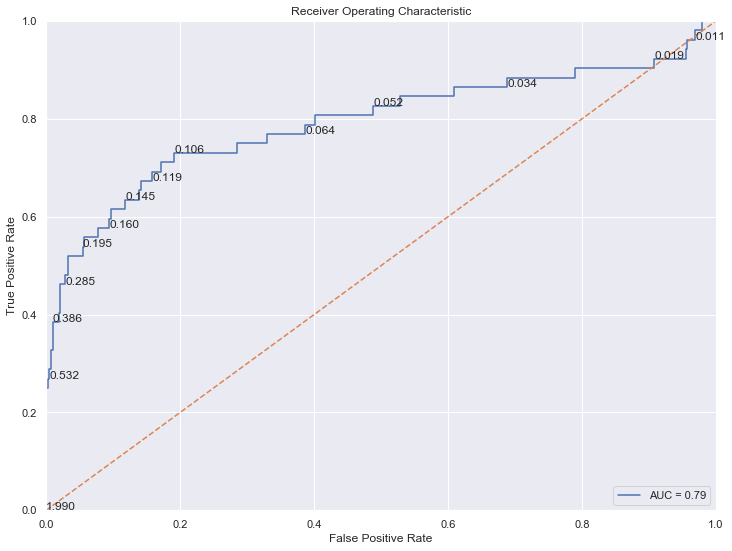

In [334]:
def create_roc_auc_plot(y, prediction_probabilities):
    fpr, tpr, thresholds = metrics.roc_curve(y, prediction_probabilities)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize=(12,9))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label = "AUC = {:.2f}".format(roc_auc))
    for i, threshold in enumerate(thresholds):
        if i % 5 == 0:
            plt.annotate("{:.3f}".format(threshold), (fpr[i], tpr[i]))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
create_roc_auc_plot(y_test, test_prediction_proba)

In [228]:
coef_table

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-7.4088,0.6219,-11.9126,0.0000,-8.6278,-6.1898
dir,4.3168,1.1526,3.7451,0.0002,2.0576,6.5759
hir,0.4814,1.4209,0.3388,0.7347,-2.3035,3.2664
lvr,2.0774,0.5553,3.7412,0.0002,0.9891,3.1657
ccs,0.2920,0.0440,6.6340,0.0000,0.2057,0.3783
mcs,0.2218,0.1558,1.4241,0.1544,-0.0835,0.5271
pbcr,1.2138,0.2249,5.3958,0.0000,0.7729,1.6546
dmi,4.2991,0.5673,7.5781,0.0000,3.1872,5.4110
self,0.5647,0.2362,2.3914,0.0168,0.1019,1.0276
single,0.3552,0.1736,2.0467,0.0407,0.0151,0.6954


In [220]:
coef_table[coef_table["P>|z|"] <= 0.05]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-7.4088,0.6219,-11.9126,0.0000,-8.6278,-6.1898
dir,4.3168,1.1526,3.7451,0.0002,2.0576,6.5759
lvr,2.0774,0.5553,3.7412,0.0002,0.9891,3.1657
ccs,0.2920,0.0440,6.6340,0.0000,0.2057,0.3783
pbcr,1.2138,0.2249,5.3958,0.0000,0.7729,1.6546
dmi,4.2991,0.5673,7.5781,0.0000,3.1872,5.4110
self,0.5647,0.2362,2.3914,0.0168,0.1019,1.0276
single,0.3552,0.1736,2.0467,0.0407,0.0151,0.6954
uria,0.0875,0.0358,2.4471,0.0144,0.0174,0.1576
black,0.6939,0.2004,3.4616,0.0005,0.3010,1.0867


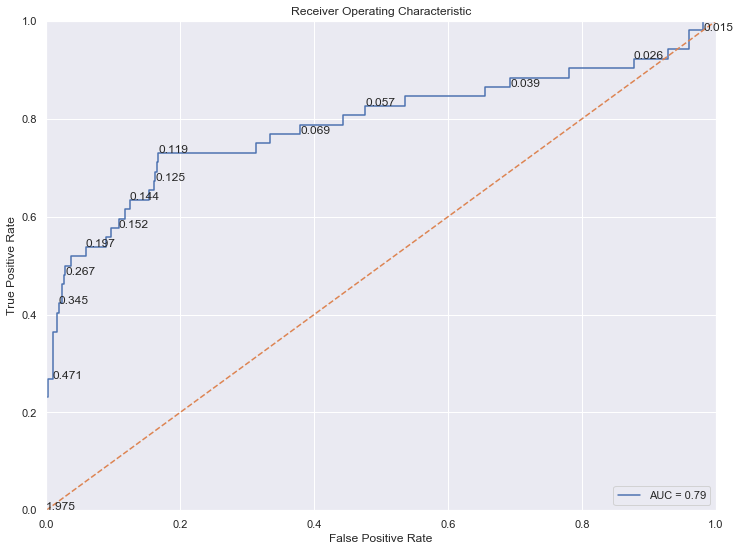

In [336]:
model_lr = LogisticRegression(solver='lbfgs')
model_lr.fit(X_train, y_train)
create_roc_auc_plot(y_test, model_lr.predict_proba(X_test)[:,1])

## Vergleich verschiedener Modelle

Instanziieren der genannten Klassifikatoren

In [347]:
classifier_dtree = DecisionTreeClassifier(criterion = 'entropy')
classifier_rforest = RandomForestClassifier(n_estimators = 10, random_state=0)
classifier_adaboost = AdaBoostClassifier()
classifier_nb = ComplementNB() #particularly suited for imbalanced data sets
classifier_svm = LinearSVC(max_iter = 10000)

classifiers = [classifier_dtree, classifier_rforest, classifier_adaboost, classifier_nb, classifier_svm]

###### Trainieren der Klassifikatoren

In [348]:
for classifier in classifiers:
    classifier.fit(X_train, y_train)

###### Vergleich der Feature Importances
In den folgenden Zellen wird ein Vergleich der Feature Importances der einzelnen Klassifikatoren durchgeführt.

Die Feature Importance, Koffizienten und _log_ der Wahrscheinlichkeit eines Features einer Klasse sind nicht direkt vergleichbar. Das liegt daran, dass sie unterschiedliche Aussagen treffen:

- Feature Importance
  - Attribut `feature_importances_` in `DecisionTreeClassifier`, `RandomForestClassifier` und `AdaBoostClassifier`)
  - Basiert darauf, wie sehr ein Attribut dazu beiträgt, den sog. "Information Gain" in einem Knoten eines Entscheidungsbaums zu erhöhen bzw. die Entropie der Daten in dessen Kind-Knoten zu verringern. Bei Random Forest wird der durchschnitt über alle Entscheidungsbäume für jedes Attribut berechnet. 


- Koffizienten
  - Attribut `coef_` in `LogisticRegression` und `LinearSVC`
  - Die Koeffizienten, die bei der Logistischen Regression bzw. beim Trainieren einer Linearen SVM gelernt für die einzelnen Merkmale gelernt wurden.


- _log_ der Wahrscheinlichkeit eines Features einer Klasse
  - Attribut `feature_log_prob_` in `ComplementNB`
  - 
  
Aufgrund dieser Informationen ist lediglich die Reihenfolge der Attribute nach ihrer Wichtigkeit im jeweiligen Klassifikator vergleichbar.

In [357]:
# Define Method to sort the feature weightings and zip them with the feature names
def zip_and_sort(feature_names, feature_weightings):
    for feature, weight in sorted(zip(feature_names, feature_weightings), key=lambda x: abs(x[1]), reverse = True):
        print('{:8s}{:.2f}'.format(feature, weight))

In [358]:
feature_names = data.drop("deny", axis=1).columns
# Print sorted feature weightings for every classifier
for feature_weightings in [#classifier_lregression.coef_[0],
                          classifier_dtree.feature_importances_,
                          classifier_rforest.feature_importances_,
                          classifier_adaboost.feature_importances_,
                          classifier_nb.feature_log_prob_[1],
                          classifier_svm.coef_[0]]:
    zip_and_sort(feature_names, feature_weightings)
    print()

lvr     0.26
dir     0.19
hir     0.13
ccs     0.10
uria    0.10
dmi     0.09
pbcr    0.03
mcs     0.03
condo   0.02
single  0.02
black   0.01
self    0.01

dir     0.21
lvr     0.19
hir     0.16
ccs     0.09
dmi     0.08
uria    0.08
pbcr    0.05
condo   0.03
mcs     0.03
black   0.03
single  0.03
self    0.02

lvr     0.42
dir     0.24
hir     0.14
ccs     0.06
dmi     0.04
pbcr    0.02
self    0.02
single  0.02
uria    0.02
black   0.02
mcs     0.00
condo   0.00

dmi     8.09
pbcr    5.28
self    4.46
black   4.41
hir     3.66
condo   3.52
dir     3.41
single  3.25
lvr     2.59
mcs     1.74
ccs     1.59
uria    0.95

dmi     1.44
dir     1.00
pbcr    0.41
lvr     0.34
black   0.18
hir     0.15
self    0.11
single  0.07
ccs     0.07
mcs     0.04
uria    0.02
condo   -0.01



###### Vorhersage im Test-Datensatz mithilfe der Klassifikatoren

In [360]:
class_name = 'Most Common Class'
score = balanced_accuracy_score(y_test, np.zeros_like(y_test))
print('{:25s}{:.2f}\n'.format(class_name, score))

# class_name = type(classifier_lregression).__name__
# score = balanced_accuracy_score(y_test, classifier_lregression.predict(X_test_scaled))
# print('{:25s}{:.2f}\n'.format(class_name, score))

for classifier in classifiers:
    class_name = type(classifier).__name__
    score = balanced_accuracy_score(y_test, classifier.predict(X_test))
    print('{:25s}{:.2f}'.format(class_name, score))


Most Common Class        0.50

DecisionTreeClassifier   0.65
RandomForestClassifier   0.62
AdaBoostClassifier       0.67
ComplementNB             0.71
LinearSVC                0.62
